# Querying DAYMET daily precipitation data using polygons from the SNAP Data API

In the notebook below, we demonstrate a method for fetching a polygon of interest from the SNAP Data API and then using this polygon's bounding box to subset DAYMET daily precipitation data. By only querying the DAYMET data in our immediate area of interest, we avoid downloading the complete dataset and having to process it locally. 

We also demonstrate using the `regionstats` package to futher clip the DAYMET dataset using the 2-dimensional polygon geometry, and compute rolling daily statistics over the time dimension. Finally, we fetch USGS stream gauge data for the Chena River and plot it alongside the precipitation statistics.

### Setup:

Load required packages.

In [2]:
from pydap.client import open_url
import xarray as xr
import geopandas as gpd
from ardac_utils import *
import requests
import shapely
import json
import numpy as np
import regionmask
import rioxarray
import matplotlib.pyplot as plt
import datetime
from pyproj import Transformer


### Define area of interest using a polygon:

From our web browser, we can search the available HUC polygons at https://earthmaps.io/places/hucs for 'Chena River'. (Use the browser's "find" function for this operation, and consider installing a browser extension that renders JSON formatting if the results are difficult to read.) 

We decide to choose the HUC8 polygon (the one with an 8-digit ID), and from its properties below we get the Chena River HUC8 code '19080306':

...
```
{
    "id": "19080306",
    "name": "Chena River",
    "type": "huc"
  },
```
...

We can use the HUC8 code to query the SNAP Data API and get a GeoJSON response. Parse the response into a EPSG:4326 geodataframe, and then reproject this to a second geodataframe in the Lambert Conformal Conic projection. (Here we use the PROJ string derived from the DAYMET projection details [here](https://daac.ornl.gov/DAYMET/guides/Daymet_Daily_V4.html#datacharact:~:text=PROJ.4%3A%20%2Bproj%3Dlcc%20%2Blat_1%3D25%20%2Blat_2%3D60%20%2Blat_0%3D42.5%20%2Blon_0%3D%2D100%20%2Bx_0%3D0%20%2By_0%3D0%20%2Bellps%3DWGS84%20%2Bunits%3Dm%20%2Bno_defs).) 

We will find the projected bounding box coordinates of the Lambert Confirmal Conic polygon which can be used to subset the DAYMET data request. 

In [3]:
proj_str = '+proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs'

with requests.Session() as s:
    response = s.get('https://earthmaps.io/boundary/area/19080306').json()
    response['the_geom'] = shapely.from_geojson(json.dumps(response))
    gdf_4326 = (gpd.GeoDataFrame([response]).set_geometry('the_geom').set_crs(4326))
    gdf_lambert = gdf_4326.to_crs(proj_str)

#order of bounding box coords is bottom left longitude, bottom left latitude, top right longitude, top right latitude 
bounds = gdf_lambert.total_bounds
x1, y1, x2, y2 = bounds[0], bounds[1], bounds[2], bounds[3]
print(x1, y1, x2, y2)

-2245166.7777520954 3025186.521815246 -2081741.944063858 3099636.0811854852


### DAYMET Background:

According to their [homepage](https://www.earthdata.nasa.gov/technology/daymet), the DAYMET project dataset "provides long-term, continuous, gridded estimates of daily weather and climatology variables from ground-based observations through statistical modeling techniques". DAYMET data is available through Oak Ridge National Laboratory Distributed Active Archive Center (ORNL DAAC), which houses and distributes a large variety of NASA data. (Read more [here](https://daac.ornl.gov/about/).)

When attempting to query these datasets programmatically, it helps to find the source DOI in the ORNL DAAC catalog. We are looking for DAYMET daily data for continental North America, which we find at this DOI: ```https://doi.org/10.3334/ORNLDAAC/2129```. Looking at the the DOI URL suffix, we can see that the dataset identifier in the ORNL DAAC catalog is ```2129```. This identifier is important, as it will become part of the URL we will build to query the ORNL DAAC THREDDS server.

While there are several data access services available on the ORNL DAAC THREDDS server, we are going to use the OPeNDAP access option to get our data. The URL structure for all OPeNDAP requests is as follows:

-  ```https://thredds/dodsC/ornldaac/<dataset_id>/<filename>```

And the filename structure is as follows:

- ```daymet_v4_daily_<region>_<variable>_<year>.nc```

_(We found this by browsing through the ORNL DAAC catalog until we reached an individual item's page, and noted it's OPeNDAP access URL pattern. See [this page](https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2129/catalog.html?dataset=2129/daymet_v4_daily_na_prcp_1996.nc) for an example item, and check out the OPeNDAP URL structure under "Access", item #1.)_  


DAYMET has 3 regions of interest. The choices are:

- na: continental North America
- hi: Hawaii
- pr: Puerto Rico

DAYMET has 7 variables. The choices are:

- all: all variables below
- dayl: duration of daylight
- prcp: daily total precipitation
- srad: incident shortwave radiation flux density (average over daylight period)
- swe: snow water equivalent
- tmax: maximum 2-meter air temperature
- tmin: minimum 2-meter air temperature
- vp: water vapor pressure (daily average)

_(variables are listed here: https://daymet.ornl.gov/single-pixel-tool-guide#:~:text=Variables%20and%20Units%3A)_

### Requesting DAYMET data:

First we define our request parameters, then we can build a list of request URLs that will fetch the data for us. We need to use multiple URLs because the DAYMET data files are split by year, and we need to make a unique request for each year of interest.

In [4]:
dataset_id = '2129'
region = 'na'
var = 'prcp'
start_year, end_year = 2000, 2003
years = [str(y) for y in range(start_year, end_year+1)]

urls = []
for y in years:
    filename = 'daymet_v4_daily_' + region + '_' + var + '_' + y + '.nc'
    url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/' + dataset_id + '/' + filename
    urls.append(url)

for url in urls:
    print(url)

https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_prcp_2000.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_prcp_2001.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_prcp_2002.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_prcp_2003.nc


Now we iterate through our list of URLs and request the DAYMET data. Note that the OPeNDAP protocol allows us to make a request and interact with the attributes of the dataset without actually downloading the file. This gives us the opportunity to subset the data to our area of interest before downloading, which is good because each yearly file is multiple gigabytes in size.

In the code snippet below, we know that our URL contains the year of interest. We also have the previously defined bounding box coordinates available to subset spatially. For the sake of this demo, let's also limit our request to May through October.

Once the dataset object has been created and subset by time and space, we will reproject the dataset to WGS84 geographic coordinates. (This will allow us to use the `regionmask` tools in later steps). Finally, we will rename one of the original coordinates to prevent any confusion with the CRS information in the reprojected dataset.

What we end up with is a list of xarray datasets, one for each year (2000-2003).

In [5]:
datasets = []

for url in urls:
    daymet_opendap = open_url(url)
    ds = xr.open_dataset(xr.backends.PydapDataStore(daymet_opendap), decode_coords="all")
    #crop to chena huc8 extent using the geographic bounds....
    #since xarray dataset coords start the top left corner (instead of bottom left, like on a map),
    #we use the max latitude as the minimum value for the slice, and the min latitude as the maximum value for the slice
    #also crop to include only months may thru oct, which are listed numerically
    ds = ds.sel(y=slice(y2,y1), x=slice(x1,x2), time=ds.time.dt.month.isin([5,6,7,8,9,10]))
    #now that we have a smaller slice of the data, we can reproject it
    ds4326 = ds.drop(['lon', 'lat']).rio.reproject("EPSG:4326").rio.write_crs("EPSG:4326")
    #clean up the dataset by renaming the DAYMET spatial reference coordinate to something more general, since we just reprojected it
    ds4326 = ds4326.rename({'lambert_conformal_conic' : 'spatial_ref'})

    datasets.append(ds4326)


Check out the data by plotting the precipitation variable for a date in one of the datasets, and plotting the Chena River watershed polygon on top of it. Though the plot uses standard lat/lon coordinates, we can see that the Lambert Conformal Conic bounding box actually selected an appropriate area around the watershed to subset.

<Axes: title={'center': 'time = 2000-06-21T12:00:00, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

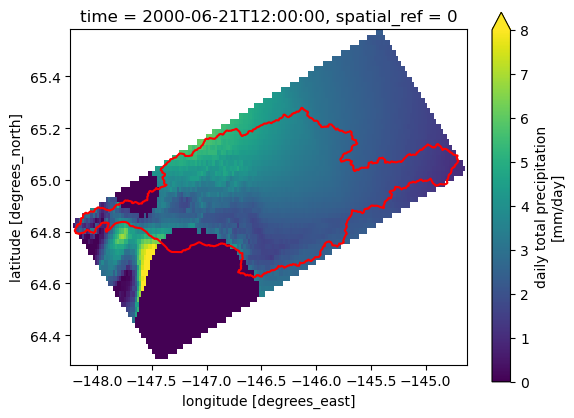

In [6]:
fig, ax = plt.subplots()

datasets[0].prcp.sel(time='06-21-2000').plot(ax=ax, vmin=0, vmax=8)
gdf_4326.boundary.plot(ax=ax, color='red')

### Visual demo of `regionmask` and incorporation of USGS stream gauge data

Seeing the watershed polygon overlaid on the DAYMET data extent, its clear that if we were to do calculate statistics on the dataset we would be including a large area outside of our region of interest. It would be much better to "clip" the dataset to the actual extent of the polygon. Using the year 2000 data, we will demonstrate how to use the `regionmask` tools to quickly apply a geometric mask to our DAYMET subset. (This process will be done for all datasets later on in the notebook, but will not be visualized.)

First, lets create a conventiently named variable to hold the data. We then create a 3D mask using the chena watershed geodataframe, and specify that the mask should mapped onto the XY grid defined by the DAYMET data. This function essentially rasterizes the polygon at the same resolution as the DAYMET data, and includes a third dimension of time in the mask.

In [7]:
chena_bbox_2000 = datasets[0]
chena_huc8_mask = regionmask.mask_3D_geopandas(gdf_4326, chena_bbox_2000.x, chena_bbox_2000.y)

Let's plot both the polygon and the 3D mask to compare their shapes and check the grid resolution.

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

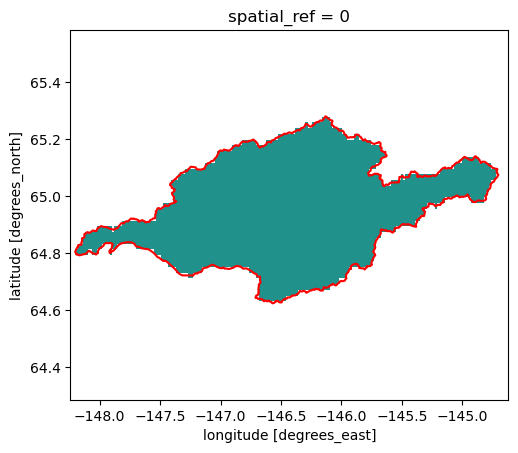

In [8]:
fig, ax = plt.subplots()
regionmask.plot_3D_mask(chena_huc8_mask, add_colorbar=False, ax=ax)
gdf_4326.boundary.plot(ax=ax, color='red')

Now we apply the 3D mask to the DAYMET dataset. This clips the dataset to the mask extent in every time slice.  You can imagine it as a cookie cutter slicing through the entire datacube. Let's plot the precipitation for same date as above, with the same colorbar. The area inside the mask look to be identical!

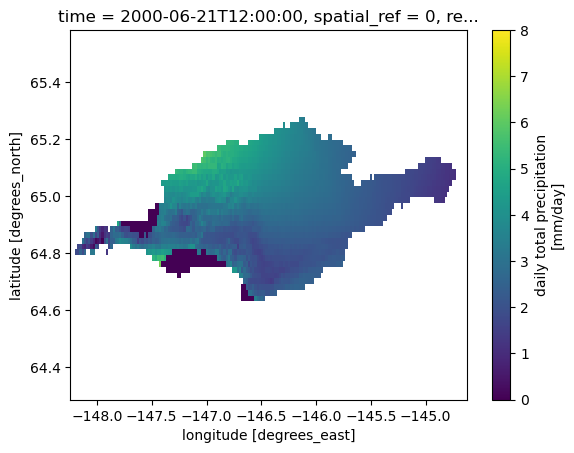

In [9]:
chena_huc8 = chena_bbox_2000.where(chena_huc8_mask)
chena_huc8.prcp.sel(time='2000-06-21').plot(vmin=0, vmax=8)

Now that the dataset is clipped, we can calculate some statistics. Let's compute a 7 day cumulative precipitation across the masked dataset. For each timestep, we will sum the precipitation of the preceding 7 days and create a new dataset from the results. To accomplish this, we use an `xarray` rolling object and specify that the rolling window is _not_ centered on the timestep, and that the sum is computed even if there are not 7 timesteps available (ie, for the first 7 days of the dataset). 

Then plot the 7-day cumulative precipitation on the same date as the plots above. We see that the range of values is now much higher, which suggests that the summing operation has been successful. We also see some interesting shapes and sharp demarcations in the plot space. Note that DAYMET is a statistical interpolated product, which estimates meterological measurements in the areas between actual observation points. You will find many instances of sharp boundary lines in this dataset due to the statistical methods used. This shows one example of why its always safer to average these data over larger areas and multiple time steps, rather than selecting single points or single dates; these data artifacts can often be smoothed out by aggregation.

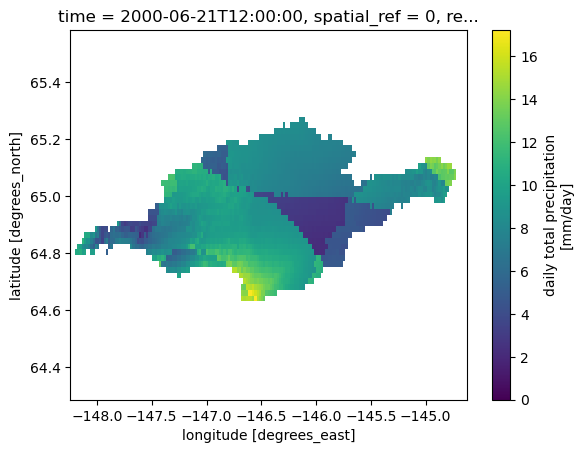

In [10]:
prcp_7day_sum = chena_huc8['prcp'].rolling(time=7, center=False, min_periods=1).sum()
prcp_7day_sum.sel(time='2000-06-21').plot(vmin=0)

Speaking of aggregation, let's do just that! For each daily time step, lets average the 7-day cumulative rainfall over the entire watershed. We will write this to a new variable in the `chena_huc8` dataset.

In [11]:
chena_huc8['basin_mean_7d_prcp'] = prcp_7day_sum.groupby('time').mean(dim=["x","y"])

Using a similar process to the DAYMET OPeNDAP requests, we can request some USGS stream gauge data to add context to our Chena River basin precipitation statistics. We will get daily mean streamflow data for the year 2000 from the USGS Chena River gauge location by using the USGS water services API. (The gauging station details can be found [here](https://waterdata.usgs.gov/nwis/inventory/?site_no=15514000&agency_cd=USGS) and more info on the API can be found [here](https://waterservices.usgs.gov/docs/statistics/statistics-details/).)

In [12]:
gauge_id = '15514000'
start_dt = '2000-05-01'
end_dt = '2000-10-31'
gauge_url = "https://waterservices.usgs.gov/nwis/dv/?format=json&sites=" + gauge_id + "&startDT=" + start_dt + "&endDT=" + end_dt + "&siteStatus=all"

with requests.Session() as s:
    response = s.get(gauge_url).json()

Parse the JSON response to get gauge location coordinates (we will use these in a later plot), and create a dictionary of observation dates and stream gauge measurements. While parsing, convert the date string into a numpy datetime object and drop the hours/minutes/seconds details; this will allow a 1:1 comparison to timesteps in our precipitation data.

For each time step in the precipitation dataset, query the dictionary to find streamflow data for that date and populate a list with the results. If no data is available for that date, populate with NAN print a message. Convert the list to an array and add this to our precipitation dataset as a new variable, creating our final result dataset for plotting.

In [13]:
gauge_lat = response['value']['timeSeries'][0]['sourceInfo']['geoLocation']['geogLocation']['latitude']
gauge_lon = response['value']['timeSeries'][0]['sourceInfo']['geoLocation']['geogLocation']['longitude']

date_val_dict = {}

for obs in response['value']['timeSeries'][0]['values'][0]['value']:
    np_date = pd.to_datetime(obs['dateTime'], format='%Y-%m-%dT%H:%M:%S.%f').to_numpy()
    np_date_dayonly = np_date.astype('datetime64[D]')
    date_val_dict[np_date_dayonly] = int(obs['value'])

streamflow = []

for t in chena_huc8.time.values:
    try:
        val = date_val_dict[t.astype('datetime64[D]')]
        streamflow.append(val)
    except:
        print(str(t) + " not found in USGS stream gauge data...")
        streamflow.append(np.nan)

result = chena_huc8.assign(streamflow_cfs = (['time'], np.array(streamflow)))

Plot the DAYMET basin-wide mean of 7d cumulative precipitation alongside the observed USGS streamflow data.

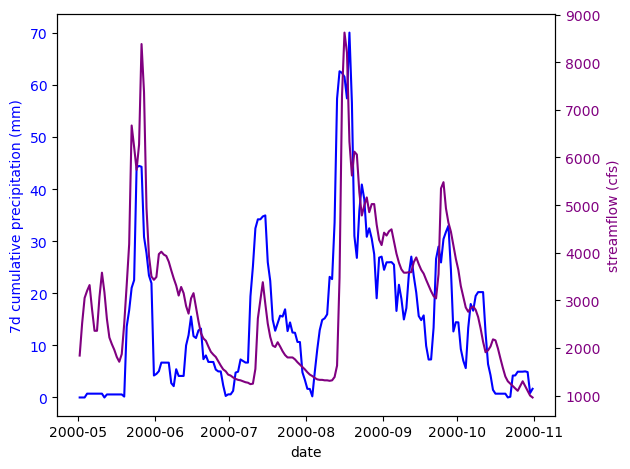

In [14]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('date')
ax1.set_ylabel('7d cumulative precipitation (mm)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.plot(result.time.values, result.basin_mean_7d_prcp.values, color='blue')

ax2 = ax1.twinx()
ax2.plot(result.time.values, result.streamflow_cfs.values, color='purple')
ax2.set_ylabel('streamflow (cfs)', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

fig.tight_layout()
plt.show()

### Plotting multiple years with a context map

Using some of the same code as in the demo above, we will loop through years 2000-2003 and create a plot like the one above for each individual year. We will also plot a map of the May-Oct mean cumulative precipitation across all years, including the USGS Chena River gauge location.

In [15]:
results = []

for ds, yr in zip(datasets, years):
    mask = regionmask.mask_3D_geopandas(gdf_4326, ds.x, ds.y)
    ds_masked = ds.where(mask)
    prcp_7day_sum = ds_masked['prcp'].rolling(time=7, center=False, min_periods=1).sum()
    ds_masked['basin_mean_7d_prcp'] = prcp_7day_sum.groupby('time').mean(dim=["x","y"])

    gauge_id = '15514000'
    start_dt = yr + '-05-01'
    end_dt = yr + '-10-31'
    gauge_url = "https://waterservices.usgs.gov/nwis/dv/?format=json&sites=" + gauge_id + "&startDT=" + start_dt + "&endDT=" + end_dt + "&siteStatus=all"

    with requests.Session() as s:
        response = s.get(gauge_url).json()

    date_val_dict = {}

    for obs in response['value']['timeSeries'][0]['values'][0]['value']:
        np_date = pd.to_datetime(obs['dateTime'], format='%Y-%m-%dT%H:%M:%S.%f').to_numpy()
        np_date_dayonly = np_date.astype('datetime64[D]')
        date_val_dict[np_date_dayonly] = int(obs['value'])

    streamflow = []

    for t in ds_masked.time.values:
        try:
            val = date_val_dict[t.astype('datetime64[D]')]
            streamflow.append(val)
        except:
            print(str(t) + " not found in USGS stream gauge data...")
            streamflow.append(np.nan)

    result = ds_masked.assign(streamflow_cfs = (['time'], np.array(streamflow)))
    results.append(result)

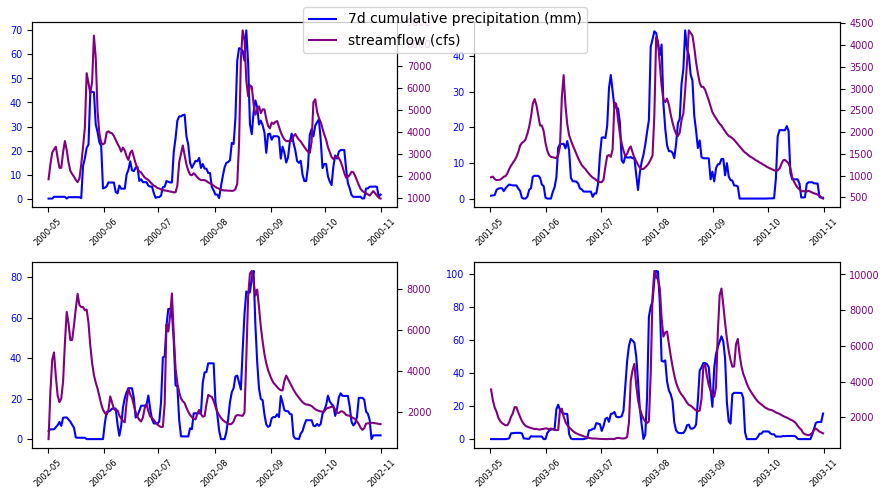

In [16]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(9,5))

#top left
ax1.tick_params(axis='x', rotation=45, labelsize=6)
#ax1.set_ylabel('7d cumulative precipitation (mm)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue', labelsize=7)
ax1.plot(results[0].time.values, results[0].basin_mean_7d_prcp.values, color='blue', label='7d cumulative precipitation (mm)')
ax1a = ax1.twinx()
ax1a.plot(results[0].time.values, results[0].streamflow_cfs.values, color='purple', label = 'streamflow (cfs)')
#ax1a.set_ylabel('streamflow (cfs)', color='purple')
ax1a.tick_params(axis='y', labelcolor='purple', labelsize=7)

#top right
ax2.tick_params(axis='x', rotation=45, labelsize=6)
#ax2.set_ylabel('7d cumulative precipitation (mm)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue', labelsize=7)
ax2.plot(results[1].time.values, results[1].basin_mean_7d_prcp.values, color='blue')
ax2a = ax2.twinx()
ax2a.plot(results[1].time.values, results[1].streamflow_cfs.values, color='purple')
#ax2a.set_ylabel('streamflow (cfs)', color='purple')
ax2a.tick_params(axis='y', labelcolor='purple', labelsize=7)

#bottom left
ax3.tick_params(axis='x', rotation=45, labelsize=6)
#ax3.set_ylabel('7d cumulative precipitation (mm)', color='blue')
ax3.tick_params(axis='y', labelcolor='blue', labelsize=7)
ax3.plot(results[2].time.values, results[2].basin_mean_7d_prcp.values, color='blue')
ax3a = ax3.twinx()
ax3a.plot(results[2].time.values, results[2].streamflow_cfs.values, color='purple')
#ax3a.set_ylabel('streamflow (cfs)', color='purple')
ax3a.tick_params(axis='y', labelcolor='purple', labelsize=7)

#bottom rightt
ax4.tick_params(axis='x', rotation=45, labelsize=6)
#ax4.set_ylabel('7d cumulative precipitation (mm)', color='blue')
ax4.tick_params(axis='y', labelcolor='blue', labelsize=7)
ax4.plot(results[3].time.values, results[3].basin_mean_7d_prcp.values, color='blue')
ax4a = ax4.twinx()
ax4a.plot(results[3].time.values, results[3].streamflow_cfs.values, color='purple')
#ax4a.set_ylabel('streamflow (cfs)', color='purple')
ax4a.tick_params(axis='y', labelcolor='purple', labelsize=7)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center')

fig.tight_layout()
plt.show()

### Map in WGS84 (EPSG:4326)

Text(0.5, 1.0, 'Chena River Basin\nMay-Oct Average Cumulative Precipitation, 2000-2003')

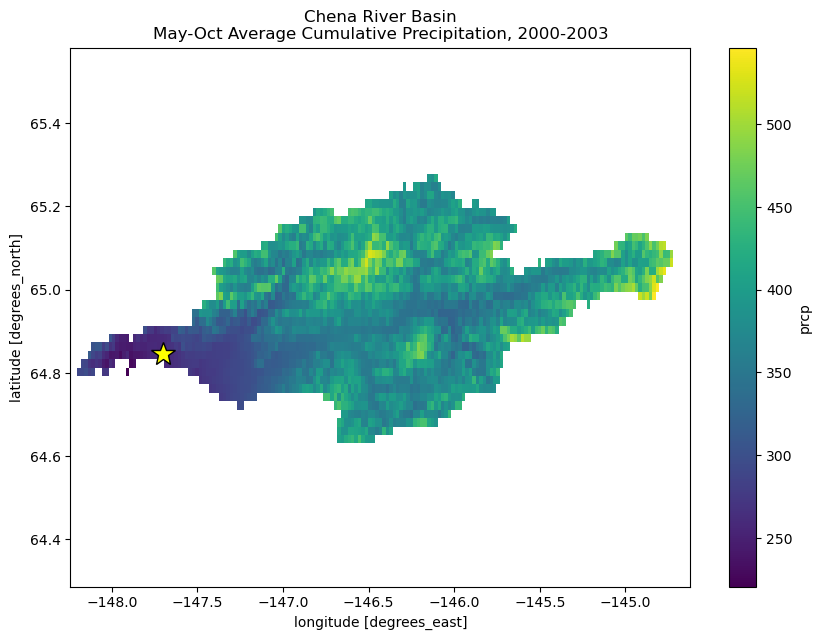

In [17]:
all_results = xr.concat(results, dim='time')
k = all_results['prcp'].sum(dim=['time'], skipna=False) / 4

fig, ax = plt.subplots(figsize=(10,7))
k.plot(ax=ax, label="May-Oct Average Cumulative Precipitation, 2000-2003")
ax.plot(gauge_lon, gauge_lat, marker='*', markersize=18, markeredgecolor='black', markerfacecolor='yellow')
ax.set_title("Chena River Basin\nMay-Oct Average Cumulative Precipitation, 2000-2003", color='black')

### Map in Alaska Albers (EPSG:3338)

Text(0.5, 1.0, 'Chena River Basin\nMay-Oct Average Cumulative Precipitation, 2000-2003')

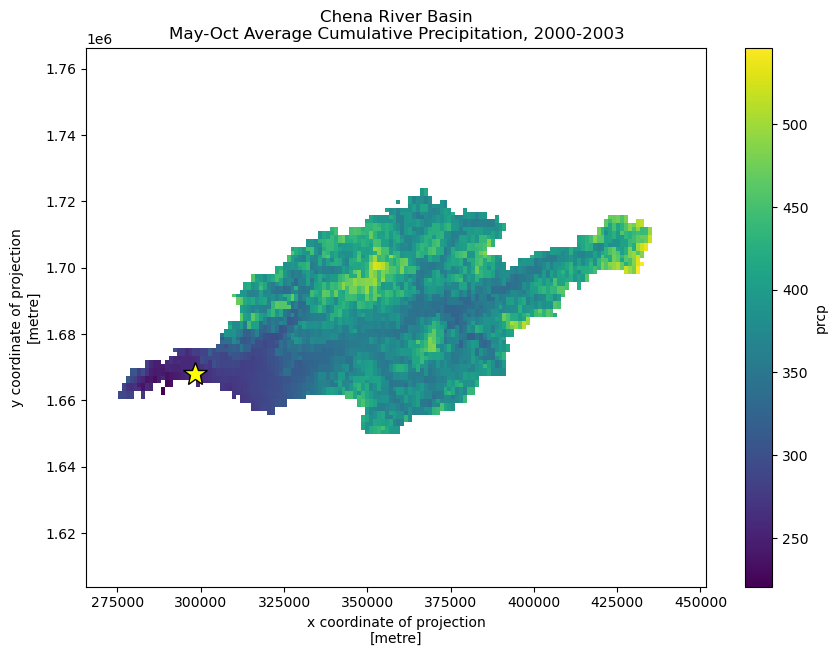

In [26]:
all_results = xr.concat(results, dim='time')
all = all_results.sel(region=0).drop('region')
m = all.sum(dim=['time'], skipna=False) / 4
n = m.rio.reproject('EPSG:3338', nodata=np.nan)

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3338", always_xy=True)
gauge_x, gauge_y = transformer.transform(xx=gauge_lon, yy=gauge_lat)

fig, ax = plt.subplots(figsize=(10,7))
n['prcp'].plot(ax=ax, label="May-Oct Average Cumulative Precipitation, 2000-2003")
ax.plot(gauge_x, gauge_y, marker='*', markersize=18, markeredgecolor='black', markerfacecolor='yellow')
ax.set_title("Chena River Basin\nMay-Oct Average Cumulative Precipitation, 2000-2003", color='black')